_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [1]:
import sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install packages in Colab
    !pip install category_encoders==2.0.0
    !pip install eli5==0.10.1
    !pip install pandas-profiling==2.3.0
    !pip install pdpbox==0.2.0
    !pip install plotly==4.1.1
    !pip install shap==0.30.0

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make all four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
train.shape, test.shape

((51916, 17), (17306, 17))

In [5]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


In [0]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train['Fail'], random_state=42)


In [7]:
train.shape, test.shape, val.shape

((41532, 17), (17306, 17), (10384, 17))

In [8]:
train.describe()

,Inspection ID,License #,Zip,Latitude,Longitude,Fail
count,4.153200e+04,4.152800e+04,41510.000000,41385.000000,41385.000000,41532.000000
mean,1.327653e+06,1.548519e+06,60628.746591,41.879559,-87.676578,0.258620
std,6.211008e+05,9.031007e+05,22.979353,0.081205,0.059327,0.437882
min,4.425100e+04,0.000000e+00,60007.000000,41.646371,-87.914428,0.000000
25%,6.793452e+05,1.139382e+06,60614.000000,41.830269,-87.707725,0.000000
50%,1.418942e+06,1.959154e+06,60625.000000,41.890196,-87.666745,0.000000
75%,1.946773e+06,2.215531e+06,60643.000000,41.939168,-87.634537,1.000000
max,2.279709e+06,8.700606e+06,60827.000000,42.021064,-87.525094,1.000000


In [9]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
State,41525,1,IL,41525
Risk,41523,3,Risk 1 (High),30143
City,41488,35,CHICAGO,41319
Inspection Type,41531,46,Canvass,19356
Facility Type,41357,292,Restaurant,27449
Inspection Date,41532,2251,2017-03-23T00:00:00,45
Location,41385,12744,"{'longitude': '-87.91442843927047', 'latitude'...",591
Address,41532,13209,11601 W TOUHY AVE,591
AKA Name,41028,15086,SUBWAY,640
DBA Name,41532,15705,SUBWAY,527


In [10]:
train['Risk'].unique()

array(['Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)', nan],
      dtype=object)

In [11]:
# Risk has 9 nan values  that are just the 0.02 % of the data 
(9/41532)*100

0.02167003756139844

In [12]:
train.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            504
License #             4
Facility Type       175
Risk                  9
Address               0
City                 44
State                 7
Zip                  22
Inspection Date       0
Inspection Type       1
Violations         7743
Latitude            147
Longitude           147
Location            147
Fail                  0
dtype: int64

In [13]:
test.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            222
License #             2
Facility Type        87
Risk                  7
Address               0
City                 18
State                 2
Zip                   8
Inspection Date       0
Inspection Type       0
Violations         3280
Latitude             61
Longitude            61
Location             61
Fail                  0
dtype: int64

In [14]:
val.isna().sum()

Inspection ID         0
DBA Name              0
AKA Name            119
License #             1
Facility Type        49
Risk                  3
Address               0
City                  9
State                 3
Zip                   4
Inspection Date       0
Inspection Type       0
Violations         1912
Latitude             51
Longitude            51
Location             51
Fail                  0
dtype: int64

In [15]:
train.dtypes

Inspection ID        int64
DBA Name            object
AKA Name            object
License #          float64
Facility Type       object
Risk                object
Address             object
City                object
State               object
Zip                float64
Inspection Date     object
Inspection Type     object
Violations          object
Latitude           float64
Longitude          float64
Location            object
Fail                 int64
dtype: object

In [16]:
train['Inspection ID'].value_counts().sum() #always unique

41532

In [18]:
train['City'].value_counts() #doesn't have any information thta I can consider important

CHICAGO              41319
Chicago                 74
chicago                 28
CCHICAGO                13
SCHAUMBURG               5
MAYWOOD                  4
CHicago                  4
ELK GROVE VILLAGE        3
CHESTNUT STREET          3
SKOKIE                   2
OAK PARK                 2
CHICAGOCHICAGO           2
ROSEMONT                 2
EAST HAZEL CREST         2
NILES NILES              2
NAPERVILLE               2
ELMHURST                 2
CICERO                   2
OOLYMPIA FIELDS          1
WORTH                    1
LAKE BLUFF               1
SCHILLER PARK            1
CHARLES A HAYES          1
BROADVIEW                1
OLYMPIA FIELDS           1
HIGHLAND PARK            1
BERWYN                   1
BOLINGBROOK              1
BRIDGEVIEW               1
BEDFORD PARK             1
EVANSTON                 1
CHICAGOI                 1
CHICAGO HEIGHTS          1
CHCHICAGO                1
ALSIP                    1
Name: City, dtype: int64

In [0]:
 #Risk drop nan values
train=train.dropna(subset=['Risk','Zip'])
val=val.dropna(subset=['Risk','Zip'])
test=test.dropna(subset=['Risk','Zip'])

#Save to use in the last part
train_id = train['Inspection ID']
val_id = val['Inspection ID']
test_id = test['Inspection ID']

In [0]:
test_original=test.copy()# I'll use this in shap

In [0]:
def wrangle(X):
    X=X.copy()
    #Risk change to caterori values
    #'Risk 1 (High)', 'Risk 2 (Medium)', 'Risk 3 (Low)'
    X['Risk']= X['Risk'].replace({'Risk 1 (High)':3,'Risk 2 (Medium)': 2,'Risk 3 (Low)':1})

    #Drop Violations because : ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15- 29, respectively)
    #Drop AKA Name because we also have the name in DBA Name (‘Doing business as’)   
    X=X.drop(['AKA Name', 'Violations','Inspection ID','City','State'], axis=1)
    X['Fail']=X['Fail'].astype('category')
    X['Zip']=X['Zip'].astype('int64')
    return X

In [22]:
print('Before Wrangle :')
train.shape, test.shape, val.shape

Before Wrangle :


((41501, 17), (17291, 17), (10377, 17))

In [0]:
train=wrangle(train)
val=wrangle(val)
test=wrangle(test)

In [24]:
print('After Wrangle :')
train.shape, test.shape, val.shape

After Wrangle :


((41501, 12), (17291, 12), (10377, 12))

In [25]:
target='Fail'
features=train.columns.drop('Fail')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((41501, 11), (41501,), (10377, 11), (10377,), (17291, 11), (17291,))

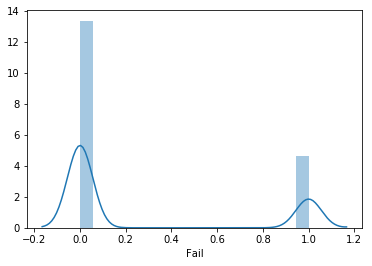

In [26]:
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100,random_state=42, n_jobs=-1)
)
pipeline.fit(X_train, y_train);

In [28]:
print('Validation score:', pipeline.score(X_val,y_val))

Validation score: 0.7233304423243712


In [29]:
from sklearn.metrics import roc_auc_score
y_val_pred_proba = pipeline.predict_proba(X_val)[:,1]
print('ROC AUC validation score:')
roc_auc_score(y_val, y_val_pred_proba)

ROC AUC validation score:


0.6630384790379296

In [30]:
pipeline.predict_proba(X_test)

array([[0.69, 0.31],
       [0.95, 0.05],
       [0.75, 0.25],
       ...,
       [0.92, 0.08],
       [0.88, 0.12],
       [0.98, 0.02]])

In [31]:
y_test_pred_proba = pipeline.predict_proba(X_test)[:,1]
print('ROC AUC test score: ')
roc_auc_score(y_test, y_test_pred_proba)

ROC AUC test score: 


0.6760060538214598

In [32]:
## Gradien Boosting
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Gradient Boosting R^2 0.06826056285497584


In [33]:
from sklearn.metrics import roc_auc_score
y_val_pred_proba = gb.predict(X_val)
print('ROC AUC validation score:')
roc_auc_score(y_val, y_val_pred_proba)

ROC AUC validation score:


0.6772780924886581

In [34]:

y_test_pred_proba = gb.predict(X_test)
print('ROC AUC test score:')
roc_auc_score(y_test, y_test_pred_proba)

ROC AUC test score:


0.6949792517415787

In [35]:
###XGBClassifier
from xgboost import XGBClassifier
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.672658	validation_1-auc:0.654258
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.673402	validation_1-auc:0.655088
[2]	validation_0-auc:0.673402	validation_1-auc:0.655088
[3]	validation_0-auc:0.673665	validation_1-auc:0.655661
[4]	validation_0-auc:0.673924	validation_1-auc:0.656095
[5]	validation_0-auc:0.679228	validation_1-auc:0.658753
[6]	validation_0-auc:0.67921	validation_1-auc:0.658682
[7]	validation_0-auc:0.681705	validation_1-auc:0.659821
[8]	validation_0-auc:0.68197	validation_1-auc:0.660188
[9]	validation_0-auc:0.681995	validation_1-auc:0.660972
[10]	validation_0-auc:0.683284	validation_1-auc:0.661969
[11]	validation_0-auc:0.683753	validation_1-auc:0.662127
[12]	validation_0-auc:0.683861	validation_1-auc:0.661933
[13]	validation_0-auc:0.686628	validation_1-auc:0.663515
[14]	validation_0-auc:0.686725	validation_1-auc:0.663766


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [36]:
X_test_processed = processor.transform(X_test)
y_pred_proba = model.predict_proba(X_test_processed)[:, 1]
print('Test ROC AUC:', roc_auc_score(y_test, y_pred_proba))

Test ROC AUC: 0.7038383195768065


## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

**Permutation Importances**

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

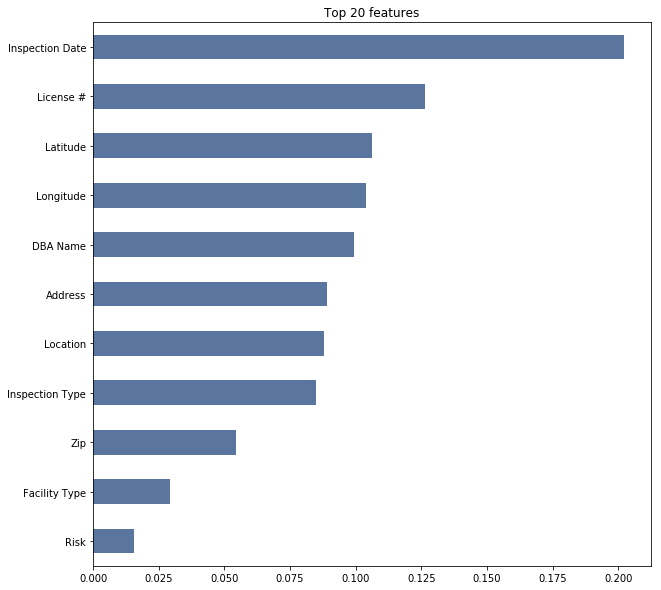

In [38]:
#Default Features 
rf_steps = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf_steps.feature_importances_, X_train.columns)

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='#5a769e');

In [39]:
#Permutation Importances using Eli5 library
pipe_eli5 = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = pipe_eli5.fit_transform(X_train)
X_val_transformed = pipe_eli5.transform(X_val)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [40]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model,
    scoring='accuracy', 
    n_iter=10, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter, 
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Using TensorFlow backend.


Weight,Feature
0.0341 ± 0.0063,Inspection Type
-0.0006 ± 0.0045,Inspection Date
-0.0023 ± 0.0030,License #
-0.0044 ± 0.0020,Facility Type
-0.0052 ± 0.0019,Risk
-0.0091 ± 0.0033,Address
-0.0100 ± 0.0026,Zip
-0.0113 ± 0.0028,Latitude
-0.0118 ± 0.0041,Longitude
-0.0119 ± 0.0035,Location


**Partial Dependence Plot, 1 feature isolation**


In [0]:
plt.rcParams['figure.dpi'] = 72

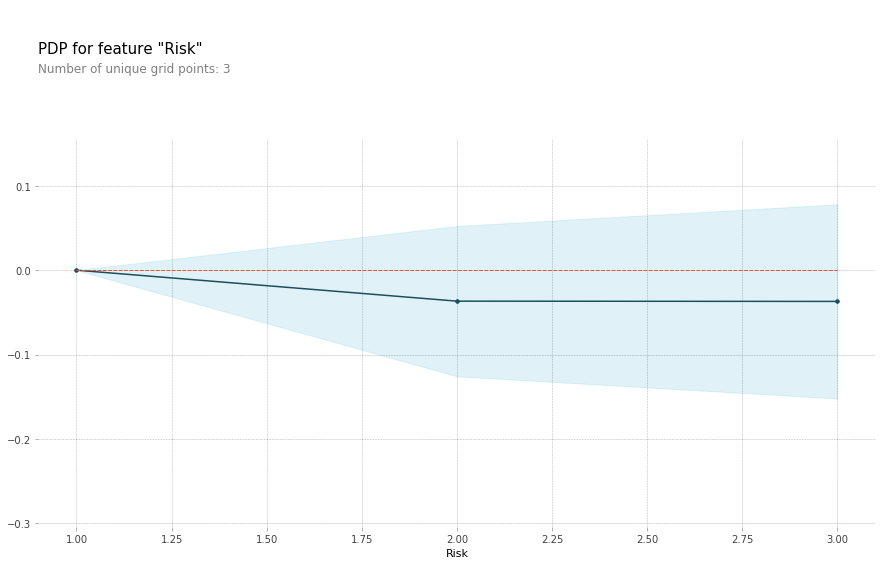

In [42]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Risk'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

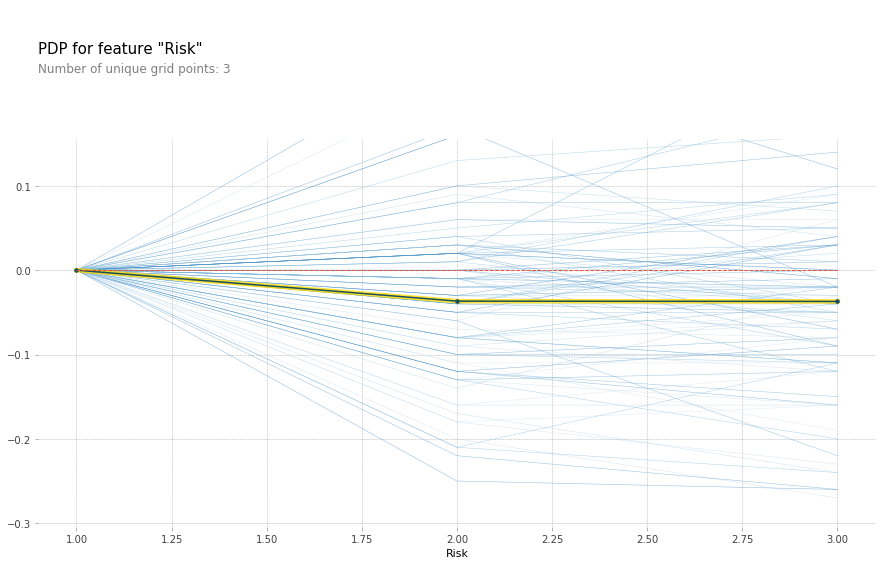

In [43]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100); # Plot 100 ICE lines


**Partial Dependence Plot, 2 features interaction**


In [44]:
X_val.dtypes

DBA Name            object
License #          float64
Facility Type       object
Risk                 int64
Address             object
Zip                  int64
Inspection Date     object
Inspection Type     object
Latitude           float64
Longitude          float64
Location            object
dtype: object

In [45]:
!pip list

Package                  Version              
------------------------ ---------------------
absl-py                  0.8.0                
alabaster                0.7.12               
albumentations           0.1.12               
altair                   3.2.0                
astor                    0.8.0                
astroid                  2.2.5                
astropy                  3.0.5                
atari-py                 0.1.15               
atomicwrites             1.3.0                
attrs                    19.1.0               
audioread                2.1.8                
autograd                 1.3                  
Babel                    2.7.0                
backcall                 0.1.0                
backports.tempfile       1.0                  
backports.weakref        1.0.post1            
beautifulsoup4           4.6.3                
bleach                   3.1.0                
blis                     0.2.4                
bokeh        

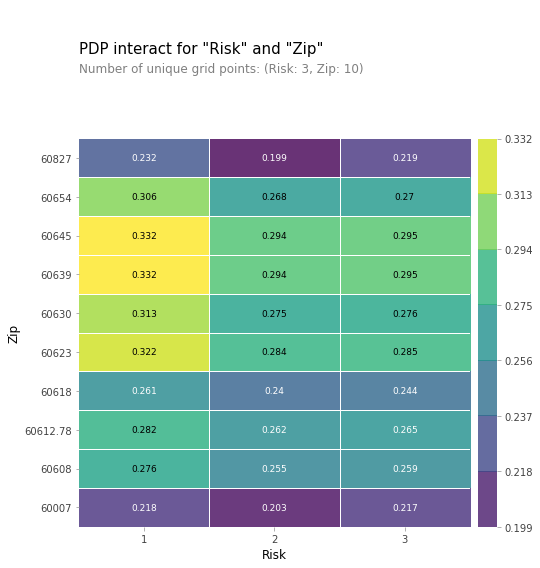

In [46]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features2 = ['Risk', 'Zip']

interaction = pdp_interact(
    model=gb, 
    dataset=X_val, 
    model_features=X_val.columns, 
    features=['Risk', 'Zip']
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=['Risk', 'Zip']);

In [47]:
len(X_val['Risk'])

10377

In [48]:
len(X_val['Zip'])

10377

**Shapley Values**

In [0]:
# to check a case we need first to create a data frame we the results of our predictios an the ID's that we saved earlier and then
#merge this data with my initial data

In [0]:
df_predictions= pd.DataFrame({'id':test_id, 'pred_proba': y_pred_proba}) #Create Data Frame with predictions

In [51]:
test.columns

Index(['DBA Name', 'License #', 'Facility Type', 'Risk', 'Address', 'Zip',
       'Inspection Date', 'Inspection Type', 'Latitude', 'Longitude',
       'Location', 'Fail'],
      dtype='object')

In [52]:
df_predictions.columns

Index(['id', 'pred_proba'], dtype='object')

In [0]:
#I changed test in the wrnagle and eliminate the id , for that reason 
#I'm going import again my data frame and drop the null values in Risk and make my merge with the tes original
test_original  = pd.read_csv(test_url)

In [0]:
test_original=test_original.dropna(subset=['Risk'])

In [55]:
test_original.columns

Index(['Inspection ID', 'DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location',
       'Fail'],
      dtype='object')

In [0]:
df_results_test= df_predictions.merge(
    test_original[['Inspection ID','Fail','DBA Name', 'AKA Name', 'License #', 'Facility Type',
       'Risk', 'Address', 'City', 'State', 'Zip', 'Inspection Date',
       'Inspection Type', 'Violations', 'Latitude', 'Longitude', 'Location']],
       how='left', left_on='id',right_on='Inspection ID'
)

In [0]:
df_results_test=df_results_test.drop('Inspection ID',axis=1)

In [58]:
df_results_test.head()

,id,pred_proba,Fail,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location
0,114835,0.152907,0,7 - ELEVEN,7 - ELEVEN,46907.0,Grocery Store,Risk 2 (Medium),600 S DEARBORN,CHICAGO,IL,60605.0,2011-03-22T00:00:00,Canvass,33. FOOD AND NON-FOOD CONTACT EQUIPMENT UTENSI...,41.874481,-87.629357,"{'longitude': '-87.62935653990546', 'latitude'..."
1,1575555,0.291723,0,TAQUERIA LOS GALLOS INC,TAQUERIA LOS GALLOS,1044860.0,Restaurant,Risk 1 (High),4209-4211 W 26TH ST,CHICAGO,IL,60623.0,2015-09-15T00:00:00,Canvass,"30. FOOD IN ORIGINAL CONTAINER, PROPERLY LABEL...",41.844070,-87.729807,"{'longitude': '-87.72980747367433', 'latitude'..."
2,671061,0.246737,0,TROTTER'S TO GO,TROTTER'S TO GO,1092634.0,Restaurant,Risk 1 (High),1337 W FULLERTON AVE,CHICAGO,IL,60614.0,2012-03-02T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",41.925128,-87.662041,"{'longitude': '-87.66204067083224', 'latitude'..."
3,1965844,0.098964,1,BIG G'S PIZZA,BIG G'S PIZZA,2334691.0,Restaurant,Risk 1 (High),1132 W TAYLOR ST,CHICAGO,IL,60607.0,2016-10-04T00:00:00,Canvass Re-Inspection,"14. PREVIOUS SERIOUS VIOLATION CORRECTED, 7-42...",41.869546,-87.655501,"{'longitude': '-87.65550098867566', 'latitude'..."
4,1751669,0.359886,1,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,SOUTH CENTRAL COMMUNITY SERVICES ELEMENTARY,3491970.0,School,Risk 2 (Medium),1021 E 83RD,CHICAGO,IL,60619.0,2016-04-08T00:00:00,Canvass,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.743933,-87.599291,"{'longitude': '-87.59929083361996', 'latitude'..."


In [0]:
fail_true = df_results_test['Fail'] == 1
not_fail = ~fail_true
correct_predict = (fail_true) == (df_results_test['pred_proba'] > 0.50)
wrong_predict = ~correct_predict

In [60]:
#Here my predictions were right
df_results_test[fail_true & correct_predict].sample(n=10, random_state=1).sort_values(by='pred_proba') 


,id,pred_proba,Fail,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location
6692,1277748,0.508195,1,PAPA JOHN'S,PAPA JOHN'S PIZZA,2069556.0,Restaurant,Risk 2 (Medium),2020 N California,CHICAGO,IL,60647.0,2013-03-20T00:00:00,Complaint,19. OUTSIDE GARBAGE WASTE GREASE AND STORAGE A...,41.918107,-87.697365,"{'longitude': '-87.69736529538596', 'latitude'..."
14340,58382,0.518877,1,DEE'S PLACE,DEE'S PLACE,2026277.0,Restaurant,Risk 1 (High),2114 W DIVISION ST,CHICAGO,IL,60622.0,2010-03-22T00:00:00,License,"16. FOOD PROTECTED DURING STORAGE, PREPARATION...",41.903246,-87.680355,"{'longitude': '-87.68035526472148', 'latitude'..."
7103,519267,0.532600,1,VIET NAM RESTAURANT,VIET NAM RESTAURANT,2121019.0,Restaurant,Risk 1 (High),1032 W ARGYLE ST,CHICAGO,IL,60640.0,2011-10-11T00:00:00,License,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,41.973403,-87.656263,"{'longitude': '-87.65626262861889', 'latitude'..."
12947,580202,0.541987,1,MARTINEZ FOOD INC.,MARTINEZ FOOD INC.,2088434.0,Grocery Store,Risk 3 (Low),3126 E 91ST ST,CHICAGO,IL,60617.0,2011-04-05T00:00:00,License,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.730228,-87.547399,"{'longitude': '-87.54739910405112', 'latitude'..."
11668,80207,0.570070,1,Delhi Darbar Kabob House,Delhi Darbar Kabob House,2013590.0,Restaurant,Risk 1 (High),3010 W Devon AVE,CHICAGO,IL,60659.0,2010-01-05T00:00:00,License,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.997576,-87.705001,"{'longitude': '-87.70500110804562', 'latitude'..."
9172,2279380,0.571444,1,BURNT CITY/DISTRICT BREW YARDS,DISTRICT BREW YARDS,2627306.0,Restaurant,Risk 1 (High),417-427 N ASHLAND AVE,CHICAGO,IL,60622.0,2019-03-14T00:00:00,License,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.889372,-87.666949,"{'longitude': '-87.66694921068412', 'latitude'..."
260,428687,0.602959,1,AMISH HEALTHY FOODS,AMISH HEALTHY FOODS,2064711.0,Grocery Store,Risk 3 (Low),1023 N WESTERN AVE,CHICAGO,IL,60622.0,2010-11-02T00:00:00,License,18. NO EVIDENCE OF RODENT OR INSECT OUTER OPEN...,41.900180,-87.686811,"{'longitude': '-87.68681129923553', 'latitude'..."
8406,233566,0.604996,1,MINI MARQUET TORRES,MINI MARQUET TORRES,2032235.0,Grocery Store,Risk 3 (Low),2324 S LEAVITT ST,CHICAGO,IL,60608.0,2010-05-06T00:00:00,License,2. FACILITIES TO MAINTAIN PROPER TEMPERATURE -...,41.849484,-87.680819,"{'longitude': '-87.68081855778911', 'latitude'..."
6755,72279,0.627131,1,MAYANA CHOCOLATE,JR DESSERT BAKERY,2022043.0,Bakery,Risk 2 (Medium),2841 W HOWARD ST,CHICAGO,IL,60645.0,2010-03-11T00:00:00,License,21. * CERTIFIED FOOD MANAGER ON SITE WHEN POTE...,42.019182,-87.701164,"{'longitude': '-87.70116444187651', 'latitude'..."
15001,2232970,0.714232,1,KABAB GRILL,KABAB GRILL,2626610.0,Restaurant,Risk 1 (High),3220-3222 W BRYN MAWR AVE,CHICAGO,IL,60659.0,2018-11-08T00:00:00,License,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.983171,-87.709709,"{'longitude': '-87.70970863394392', 'latitude'..."


In [0]:
#Shap: is a technique to check what were the features that my model consider to predict my my resut in a particular case

In [62]:
test_original['Violations'].value_counts()

45. FOOD HANDLER REQUIREMENTS MET - Comments: ALL FOOD HANDLING EMPLOYEES MUST SHOW PROOF OF FOOD HANDLER TRAINING.  MUST PROVIDE.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [0]:
#For example in the row 11296 we can se a violations to the number 
#18. NO EVIDENCE OF RODENT OR INSECT OUTER OPENINGS PROTECTED/RODENT PROOFED, A WRITTEN LOG SHALL BE MAINTAINED AVAILABLE TO THE INSPECTORS - 
#Comments: All necessary control measures shall be used to effectively minimize or eliminate the presence of rodents, roaches, and other vermin and insects on the 
#premises of all food establishments, in food-transporting vehicles, and in vending machines.  
#OBSERVED 10-15 MICE DROPPINGS SCATTERED ON FLOOR AND IN CORNERS IN PAPER GOOD STORAGE, 10-15 MICE DROPPINGS ON FLOORS, WALLS AND OUTLETS IN DRY FOOD STORAGE AREA, 
#10-15 MICE DROPPINGS ALONG WALLS IN REAR RECEIVING STORAGE AREA, 10-15 MICE DROPPINGS NEAR PIPE FITTINGS AND DEAD MOUSE ON FLOOR IN REAR ELECTRICAL ROOM, 
#5 MICE DROPPINGS ON TABLE NEAR COMPUTER EQUIPMENT AND FLOOR IN KITCHEN, 5 MICE DROPPINGS ON LEDGE BEHIND OVEN AND HOT HOLDING CABINET IN KITCHEN, 
#2 MICE DROPPINGS ON TABLE NEAR RADIO AND FLOOR UNDER DESK IN TEACHERS LOUNGE. INSTRUCTED MANAGER TO CALL AN EXTERMINATOR FOR SERVICE, CLEAN AND SANITIZE ALL AREAS. 
#SERIOUS VIOLATION 7-38-020 CITATION ISSUED.
row = X_test.iloc[[7284]]

In [64]:
X_test.iloc[[13770]]

,DBA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Latitude,Longitude,Location
13781,MR GING CHOP SUEY RESTAURANT,1193775.0,Restaurant,3,3549 N CENTRAL AVE,60634,2011-03-10T00:00:00,Canvass,41.94554,-87.766597,"{'longitude': '-87.76659733214561', 'latitude'..."


In [65]:
from xgboost import XGBClassifier
processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=100, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.672658	validation_1-auc:0.654258
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.673402	validation_1-auc:0.655088
[2]	validation_0-auc:0.673402	validation_1-auc:0.655088
[3]	validation_0-auc:0.673665	validation_1-auc:0.655661
[4]	validation_0-auc:0.673924	validation_1-auc:0.656095
[5]	validation_0-auc:0.679228	validation_1-auc:0.658753
[6]	validation_0-auc:0.67921	validation_1-auc:0.658682
[7]	validation_0-auc:0.681705	validation_1-auc:0.659821
[8]	validation_0-auc:0.68197	validation_1-auc:0.660188
[9]	validation_0-auc:0.681995	validation_1-auc:0.660972
[10]	validation_0-auc:0.683284	validation_1-auc:0.661969
[11]	validation_0-auc:0.683753	validation_1-auc:0.662127
[12]	validation_0-auc:0.683861	validation_1-auc:0.661933
[13]	validation_0-auc:0.686628	validation_1-auc:0.663515
[14]	validation_0-auc:0.686725	validation_1-auc:0.663766


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [66]:
import shap

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value, 
    shap_values=shap_values, 
    features=row
)